In [ ]:
import numpy as np
from tensorflow import keras
from keras import layers

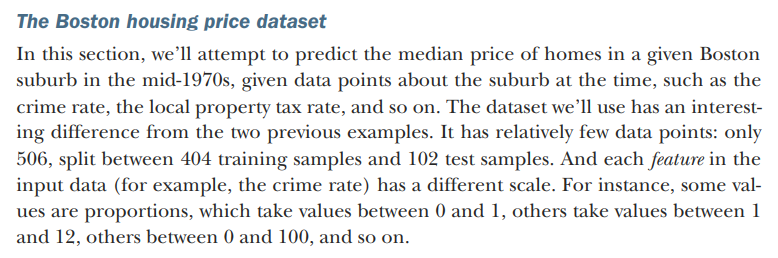

In [ ]:
# Loading the Boston housing dataset.
from tensorflow.keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [ ]:
train_data.shape

(404, 13)

In [ ]:
train_data.shape

(404, 13)

In [ ]:
targets_min = np.min(train_targets)
targets_max = np.max(train_targets)
print(targets_max,targets_min)


50.0 5.0


In [ ]:
# Normalizing the data.
mean = train_data.mean(axis = 0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
test_data -= mean
test_data /= std

Note that the quantities used for normalizing the test data are computed using the
training data. You should never use any quantity computed on the test data in your
workflow, even for something as simple as data normalization.

In [ ]:
# Model definition.
def build_model():
  model = keras.Sequential([
      layers.Dense(64,activation= "relu"),
      layers.Dense(64,activation= "relu"),
      layers.Dense(1)
  ])
  model.compile(optimizer= "rmsprop",loss= "mse", metrics= ["mae"])
  return model

In [ ]:
# K-fold validation.
k = 4
num_val_samples = len(train_data)// k
num_epochs = 100
all_scores = []
for i in range(k):
  print(f"processing fold {i}")
  val_data = train_data[i * num_val_samples: (i+1)*num_val_samples]
  val_targets = train_targets[i*num_val_samples: (i+1)*num_val_samples]
  partial_train_data = np.concatenate(
      [train_data[:i*num_val_samples],
      train_data[(i+1)*num_val_samples:]],
      axis = 0
  )
  partial_train_targets = np.concatenate(
      [train_tragets[:i* num_val_samples],
       train_targets[(i+1)*num_val_samples:]],
      axis = 0
  )
  model = build_model()
  model.fit(partial_train_data, partial_train_targets, epochs = num_epochs, batch_size= 16,verbose= 0)
  val_mse, val_mae = model.evaluate(val_data, val_targets)
  all_scores.append(val_mae)

processing fold 0
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.5543 - mae: 1.7851  
processing fold 1
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 10.5878 - mae: 2.5030  
processing fold 2
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 13.2752 - mae: 2.5172 
processing fold 3
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 12.4664 - mae: 2.3675  


In [ ]:
all_scores

[1.8643490076065063,
 2.4074912071228027,
 2.3714962005615234,
 2.3787500858306885]

In [ ]:
np.mean(all_scores)

np.float64(2.2555216252803802)

We're off by $2,600$ on average,
which is significant considering that the prices range from $10,000$ to $50,000$.

In [ ]:
# Saving the validation logs at each fold.
num_epochs = 500
all_mae_histories = []
for i in range(k):
 print(f"Processing fold #{i}")
 val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
 val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
 partial_train_data = np.concatenate(
 [train_data[:i * num_val_samples],
 train_data[(i + 1) * num_val_samples:]],
 axis=0)
 partial_train_targets = np.concatenate(
 [train_targets[:i * num_val_samples],
 train_targets[(i + 1) * num_val_samples:]],
 axis=0)
 model = build_model()
 history = model.fit(partial_train_data, partial_train_targets,
 validation_data=(val_data, val_targets),
 epochs=num_epochs, batch_size=16,verbose= 0)
 mae_history = history.history["val_mae"]
 all_mae_histories.append(mae_history)

In [ ]:
#  Building the history of successive mean K-fold validation scores
average_mae_history = [
 np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

Text(0, 0.5, 'Validation MAE')

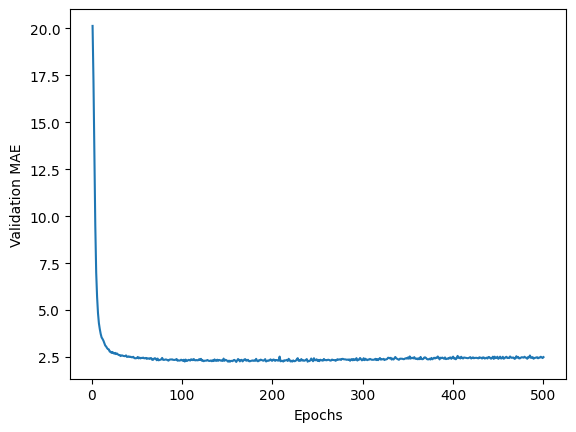

In [ ]:
# Plotting validation scores.
import matplotlib.pyplot as plt
plt.plot(range(1,len(average_mae_history)+1),average_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")

It may be a little difficult to read the plot, due to a scaling issue: the validation MAE
for the first few epochs is dramatically higher than the values that follow. Let’s omit
the first 10 data points, which are on a different scale than the rest of the curve.

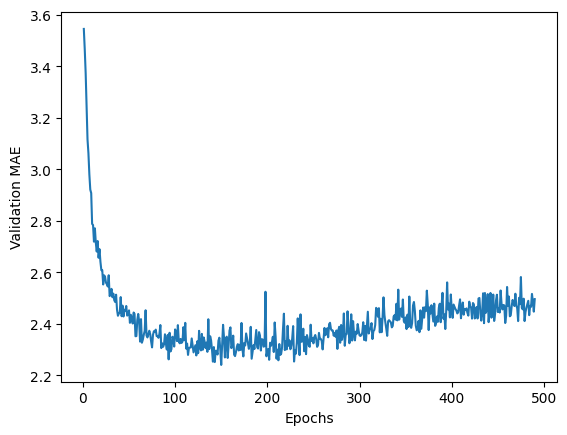

In [ ]:
# Plotting validation scores, excluding the first 10 data points
truncated_mae_history = average_mae_history[10:]
plt.plot(range(1, len(truncated_mae_history) + 1), truncated_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

As you can see in fig, validation MAE stops improving significantly after
120–140 epochs (this number includes the 10 epochs we omitted). Past that point,
we start overfitting.

In [ ]:
# Training the final model
model = build_model()
model.fit(train_data,train_tragets,epochs= 130, batch_size=16, verbose= 0)
test_mse_score, test_mae_score = model.evaluate(test_data,test_targets)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 11.1242 - mae: 2.2525 


In [ ]:
test_mae_score

2.4185402393341064